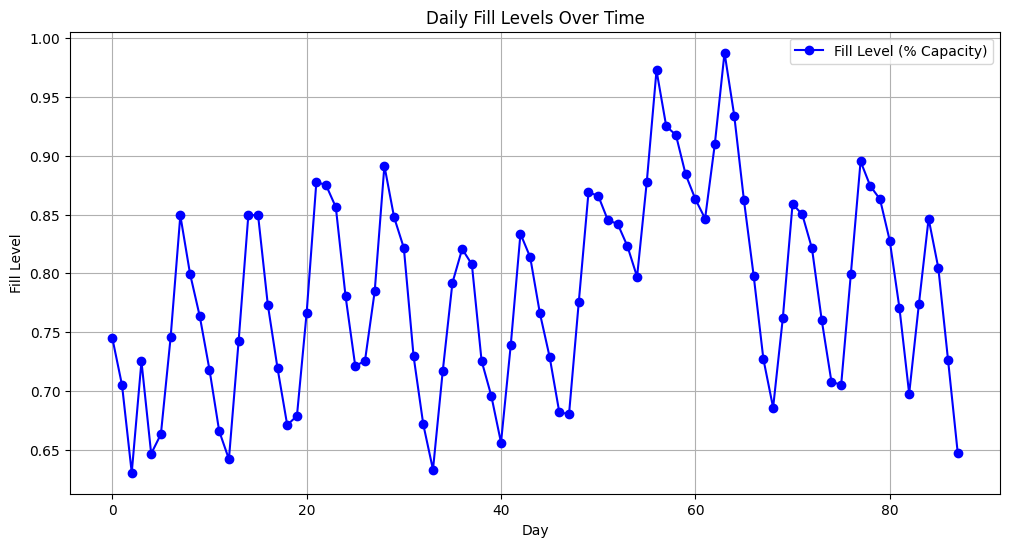

Peak Supply Day: week            10.000000
day             64.000000
net_change    1518.000000
fill_level       0.987649
Name: 63, dtype: float64
Lowest Supply Day: week             2.000000
day              3.000000
net_change   -1454.000000
fill_level       0.630484
Name: 2, dtype: float64


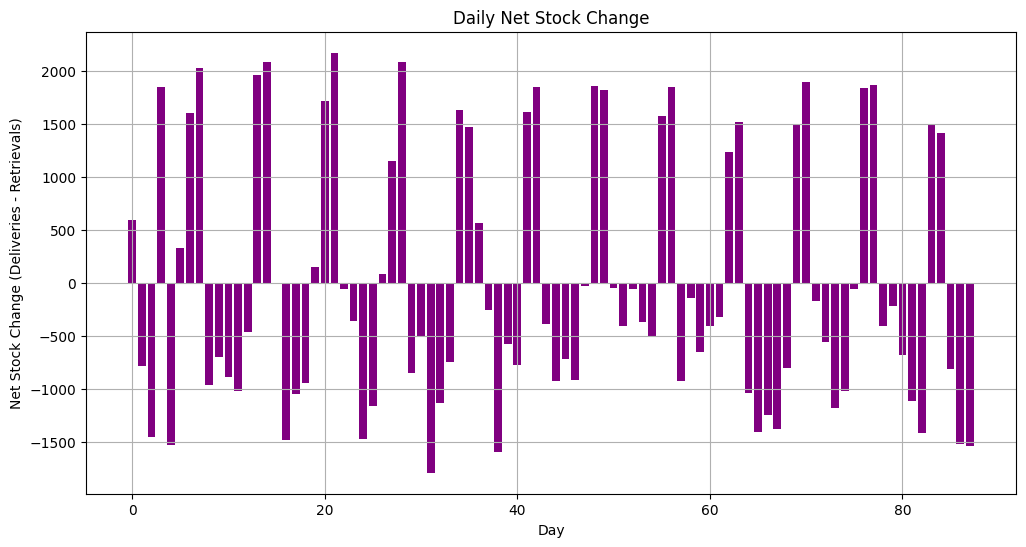

Summary of Analysis:
Peak Day (Highest Fill Level): Week 10.0, Day 64.0
Low Supply Day (Lowest Fill Level): Week 2.0, Day 3.0


In [6]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

# Load the orders and initial fill data
orders = json.load(open("../1_environment/slapstack/slapstack/use_cases/wepastacks/2_orders.json"))
initial_fill = json.load(open("../1_environment/slapstack/slapstack/use_cases/wepastacks/3_initial_fill_lvl.json"))

# Constants
TOTAL_CAPACITY = 19512  # Adjust based on actual warehouse capacity if different

# Step 1: Split orders into daily partitions and calculate daily fill levels
def split_orders_by_day(orders, initial_fill, total_capacity=TOTAL_CAPACITY):
    # Initialize storage structures
    order_data_by_day = {}
    skus = initial_fill.copy()
    
    # Group orders by week and day within the week
    for order in orders:
        week = order[-1]  # Assuming the week is the last item in the order tuple
        time = order[2]  # Assuming time is the second-to-last item in the order tuple
        day = time // 86400  # Calculate the day within the week (0 to 6)

        if week not in order_data_by_day:
            order_data_by_day[week] = {}
        if day not in order_data_by_day[week]:
            order_data_by_day[week][day] = []
        
        order_data_by_day[week][day].append(order)

    # Calculate daily fill levels
    daily_fill_levels = []
    for week, days in order_data_by_day.items():
        for day, daily_orders in days.items():
            daily_net_change = 0
            for order in daily_orders:
                order_type, sku = order[0], str(order[1])
                if order_type == "delivery":
                    skus[sku] = skus.get(sku, 0) + 1
                    daily_net_change += 1
                elif order_type == "retrieval":
                    skus[sku] = skus.get(sku, 0) - 1
                    daily_net_change -= 1

            # Calculate the fill level as a percentage of total capacity
            daily_fill_percentage = sum(skus.values()) / total_capacity
            daily_fill_levels.append({
                'week': week,
                'day': day,
                'net_change': daily_net_change,
                'fill_level': daily_fill_percentage
            })

    return pd.DataFrame(daily_fill_levels)

# Step 2: Analyze and visualize daily fill levels
def analyze_daily_fill_levels(df):
    # Plot fill level across days
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['fill_level'], marker='o', color='blue', label='Fill Level (% Capacity)')
    plt.xlabel('Day')
    plt.ylabel('Fill Level')
    plt.title('Daily Fill Levels Over Time')
    plt.legend()
    plt.grid()
    plt.show()

    # Identify peak and low supply days
    peak_day = df.loc[df['fill_level'].idxmax()]
    low_supply_day = df.loc[df['fill_level'].idxmin()]
    
    print("Peak Supply Day:", peak_day)
    print("Lowest Supply Day:", low_supply_day)

    # Plot daily net changes (Deliveries - Retrievals)
    plt.figure(figsize=(12, 6))
    plt.bar(df.index, df['net_change'], color='purple')
    plt.xlabel('Day')
    plt.ylabel('Net Stock Change (Deliveries - Retrievals)')
    plt.title('Daily Net Stock Change')
    plt.grid()
    plt.show()

    return peak_day, low_supply_day

# Step 3: Run analysis on loaded data
df_daily_fill = split_orders_by_day(orders, initial_fill)
peak_day, low_supply_day = analyze_daily_fill_levels(df_daily_fill)

# Print summary of peak and low supply days
print("Summary of Analysis:")
print(f"Peak Day (Highest Fill Level): Week {peak_day['week']}, Day {peak_day['day']}")
print(f"Low Supply Day (Lowest Fill Level): Week {low_supply_day['week']}, Day {low_supply_day['day']}")


In [7]:
# Set criteria for partition selection
high_activity_threshold = df_daily_fill['net_change'].quantile(0.75)  # Top 25% activity
low_activity_threshold = df_daily_fill['net_change'].quantile(0.25)   # Bottom 25% activity
peak_fill_threshold = df_daily_fill['fill_level'].quantile(0.75)      # Top 25% fill level
low_fill_threshold = df_daily_fill['fill_level'].quantile(0.25)       # Bottom 25% fill level

# Select partitions for each scenario
high_activity_partitions = df_daily_fill[df_daily_fill['net_change'] >= high_activity_threshold]
low_activity_partitions = df_daily_fill[df_daily_fill['net_change'] <= low_activity_threshold]
peak_fill_partitions = df_daily_fill[df_daily_fill['fill_level'] >= peak_fill_threshold]
low_fill_partitions = df_daily_fill[df_daily_fill['fill_level'] <= low_fill_threshold]

# Select sample partitions representing different scenarios
sample_partitions = pd.concat([
    high_activity_partitions.sample(min(5, len(high_activity_partitions)), replace=False),  
    low_activity_partitions.sample(min(5, len(low_activity_partitions)), replace=False),   
    peak_fill_partitions.sample(min(5, len(peak_fill_partitions)), replace=False),      
    low_fill_partitions.sample(min(5, len(low_fill_partitions)), replace=False)        
]).drop_duplicates().reset_index(drop=True)

# Display the selected partitions
print("Selected Partitions for Training:")
print(sample_partitions[['week', 'day', 'net_change', 'fill_level']])

Selected Partitions for Training:
    week  day  net_change  fill_level
0      2    4        1848    0.725195
1      8   49        1855    0.775472
2      7   43        1851    0.833692
3     11   70        1487    0.762095
4      4   22        2172    0.877870
5     11   68       -1382    0.727091
6     12   74       -1186    0.760404
7      4   18       -1054    0.719506
8      3   12       -1019    0.665847
9     14   88       -1546    0.647191
10    11   71        1892    0.859061
11     5   23         -57    0.874949
12    10   58        -926    0.925174
13     3   15        2088    0.849580
14    10   64        1518    0.987649
15     7   40        -581    0.695879
16     4   19        -945    0.671074
17     6   33       -1134    0.671587
18    13   83       -1421    0.697673
